In [1]:
import os
import time
import datetime
import numpy as np
import warnings
import random
from PIL import Image
from tqdm import tqdm

from labels import labels

In [2]:
# 데이터 경로
#  os.getcwd() :'/home/ag/Capstone2/DeepLab_V3_ver1'
origin_data_path = os.getcwd() + '/data/Original_data/'
labeled_data_path = os.getcwd() + '/data/Labeled_data/'

origin_data_list = os.listdir(origin_data_path) # x
labeled_data_list = os.listdir(labeled_data_path) # y

# 파일명 랜덤
random.shuffle(origin_data_list)
random.shuffle(labeled_data_list)

# train, test / x, y 
train_x_file = origin_data_list[:int(len(origin_data_list)*0.8)]
train_y_file = [file_name[:-4] + '_L.png' for file_name in train_x_file]

test_x_file = [file_name for file_name in origin_data_list if file_name not in train_x_file]
test_y_file = [file_name[:-4] + '_L.png' for file_name in test_x_file]

In [3]:
print(len(train_x_file), len(test_x_file), len(train_y_file), len(test_y_file))

560 141 560 141


In [4]:
print(train_x_file[0], test_x_file[0], train_y_file[0], test_y_file[0])

Seq05VD_f02220.png 0016E5_08107.png Seq05VD_f02220_L.png 0016E5_08107_L.png


### X

In [5]:
train_x = [np.array(Image.open(origin_data_path + train)) for train in train_x_file]
test_x = [np.array(Image.open(origin_data_path + test)) for test in test_x_file]

### Y

In [6]:
# color to label catId
color2label = { label.color   : label.id for label in labels}

In [7]:
train_y = []
for file_name in tqdm(train_y_file):
    image = np.array(Image.open(labeled_data_path + file_name))
    ret = [[color2label[tuple([r[0], r[1], r[2]])] 
            if tuple([r[0], r[1], r[2]]) in color2label else 11
            for r in row] 
           for row in image]
    train_y.append(ret)

100%|██████████| 560/560 [21:43<00:00,  2.33s/it]


In [8]:
test_y = []
for file_name in tqdm(test_y_file):
    image = np.array(Image.open(labeled_data_path + file_name))
    ret = [[color2label[tuple([r[0], r[1], r[2]])] 
            if tuple([r[0], r[1], r[2]]) in color2label else 11
            for r in row] 
           for row in image]
    test_y.append(ret)

100%|██████████| 141/141 [05:28<00:00,  2.33s/it]


In [9]:
np.array(train_y).shape, np.array(test_y).shape

((560, 720, 960), (141, 720, 960))

In [10]:
train_x = np.array(train_x)
train_y = np.array(train_y)
test_x = np.array(test_x)
test_y = np.array(test_y)

### data save

In [11]:
np.savez('data.npz', train_x=train_x, train_y=train_y, test_x=test_x, test_y=test_y)

# Model

### package load

In [1]:
import os
import sys
import time
import datetime
from tqdm import tqdm
import numpy as np
import warnings
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import torchvision.transforms.functional as TF

In [2]:
from model import convert_bn_to_instancenorm, convert_bn_to_evonorm, convert_bn_to_groupnorm, DeepLabHead, UNet
from helpers import AverageMeter, ProgressMeter, iouCalc, visim, vislbl
from labels import labels

### CPU or GPU
#### 아래 코드에서 True이면 GPU 사용, False 이면 CPU 사용됨.

In [3]:
USE_CUDA = torch.cuda.is_available() and True 
device = torch.device('cuda' if USE_CUDA else 'cpu')

### data load

In [4]:
npzfile = np.load('data.npz')

train_x = npzfile['train_x']
train_y = npzfile['train_y']
test_x = npzfile['test_x']
test_y = npzfile['test_y']

npzfile.close()

### DeepLab v3 ResNet50 

In [5]:
model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=False).to(device)
model.classifier = DeepLabHead(2048, 12).to(device) # 12 = class num

In [6]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=2) # 파라미터 학습속도 조절

In [7]:
# Initialize metrics
best_miou = 0.0
metrics = {'train_loss' : [],
           'train_acc' : [],
           'test_acc' : [],
           'test_loss' : [],
           'miou' : []}
start_epoch = 0

### Label 

In [8]:
# Create list of class names
classLabels = []
for label in labels:
    if label.name not in classLabels:
        classLabels.append(label.name)
classLabels.append('void')

In [9]:
validClasses = list(np.unique([label.id for label in labels if label.id >= 0] + [11]))

In [10]:
len(classLabels), len(validClasses), classLabels[0], validClasses[0]

(12, 12, 'Pole', 0)

### train

In [11]:
train_X = torch.tensor(train_x, dtype=torch.float32)
train_Y = torch.tensor(train_y, dtype=torch.long)

train_data = torch.utils.data.TensorDataset(train_X.permute(dims=(0, 3, 1, 2)), train_Y)

train_data = torch.utils.data.DataLoader(train_data, batch_size=2, shuffle=True)

In [12]:
dist = {i:(train_Y == i).sum().tolist() for i in range(12)}

In [13]:
weights = [1/dist[i] for i in range(12)]
total_weights = sum(weights)

In [14]:
class_weight = torch.FloatTensor([w/total_weights for w in weights]).to(device)
criterion = nn.CrossEntropyLoss(weight = class_weight, ignore_index=12) # weight 파라미터에 class_weight 추가

In [15]:
num_epoch = 20
res = train_X.shape[1] * train_X.shape[2]

In [16]:
for epoch in range(num_epoch):
    model.train()
    
    # batch_time = AverageMeter('Time', ':6.3f')
    # data_time = AverageMeter('Data', ':6.3f')
    loss_running = AverageMeter('Loss', ':.4e')
    acc_running = AverageMeter('Accuracy', ':.3f')  
    iou = iouCalc(classLabels, validClasses, voidClass = 11)
    progress = ProgressMeter(
        len(train_data),
        [loss_running, acc_running],
        prefix="Train, epoch: [{}]".format(epoch))

    batch_loss = 0.0
    for batch, (x, y) in enumerate(tqdm(train_data, total=len(train_data))):
        x = x.to(device)
        y = y.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward pass
        outputs = model(x)
        outputs = outputs['out']
        preds = torch.argmax(outputs, 1)
        
        # cross-entropy loss
        loss = criterion(outputs, y)

        # backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        bs = x.size(0)
        loss = loss.item()
        loss_running.update(loss, bs)
        corrects = torch.sum((preds == y) & (y != 12))
        
        nvoid = int((y==12).sum())
        acc = corrects.double()/(bs*res-nvoid)
        acc_running.update(acc, bs)
        
        # Calculate IoU scores of current batch
        iou.evaluateBatch(preds, y)
        
#         progress.display(batch)
        
     
    scheduler.step(loss_running.avg)
    miou = iou.outputScores()
    
    print('train epoch ', epoch+1)
    print('loss : {:.4f}   acc : {:.4f}   miou : {:.4f}'.format(loss_running.avg, acc_running.avg, miou))
    
    # save checkpoint per epoch
    now = datetime.datetime.now()
    now_time = now.strftime('%y%m%d_%H:%M')
    
    # save path
    if not os.path.isdir(os.getcwd() + '/result'):
        os.makedirs(os.getcwd() + '/result')
    
    save_path = os.getcwd() + '/result/'
    
    with open(save_path + '03_resnet50_log_epoch.csv', 'a') as epoch_log:
            epoch_log.write('{}, {:.5f}, {:.5f}, {:.5f}\n'.format(
                    epoch+1, loss_running.avg, acc_running.avg, miou))
    
    # Save best model to file
    torch.save({
        'epoch' : epoch,
        'model_state_dict' : model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_miou': best_miou,
        'metrics': metrics,
        }, save_path + now_time + '_checkpoint.pth.tar')
    
    # Save best model to file
    if miou > best_miou:
        print('mIoU improved from {:.4f} to {:.4f}.'.format(best_miou, miou))
        best_miou = miou
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            }, save_path + now_time + '_best_weights.pth.tar')


100%|██████████| 280/280 [04:39<00:00,  1.00it/s]


classes           IoU
---------------------
Pole          : 0.147
SignSymbol    : 0.197
Bicyclist     : 0.296
Pedestrian    : 0.255
Building      : 0.577
Fence         : 0.328
Pavement      : 0.591
Road          : 0.844
Car           : 0.632
Sky           : 0.808
Tree          : 0.637
---------------------
Mean IoU      : 0.483
---------------------
train epoch  1
loss : 0.8462   acc : 0.7626   miou : 0.4830
mIoU improved from 0.0000 to 0.4830.


100%|██████████| 280/280 [04:40<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.281
SignSymbol    : 0.442
Bicyclist     : 0.571
Pedestrian    : 0.468
Building      : 0.762
Fence         : 0.565
Pavement      : 0.749
Road          : 0.922
Car           : 0.810
Sky           : 0.879
Tree          : 0.766
---------------------
Mean IoU      : 0.656
---------------------
train epoch  2
loss : 0.4362   acc : 0.8667   miou : 0.6560
mIoU improved from 0.4830 to 0.6560.


100%|██████████| 280/280 [04:40<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.326
SignSymbol    : 0.524
Bicyclist     : 0.659
Pedestrian    : 0.547
Building      : 0.805
Fence         : 0.626
Pavement      : 0.788
Road          : 0.935
Car           : 0.841
Sky           : 0.890
Tree          : 0.786
---------------------
Mean IoU      : 0.702
---------------------
train epoch  3
loss : 0.3507   acc : 0.8871   miou : 0.7024
mIoU improved from 0.6560 to 0.7024.


100%|██████████| 280/280 [04:40<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.362
SignSymbol    : 0.579
Bicyclist     : 0.706
Pedestrian    : 0.586
Building      : 0.836
Fence         : 0.699
Pavement      : 0.815
Road          : 0.946
Car           : 0.868
Sky           : 0.897
Tree          : 0.808
---------------------
Mean IoU      : 0.737
---------------------
train epoch  4
loss : 0.2870   acc : 0.9035   miou : 0.7367
mIoU improved from 0.7024 to 0.7367.


100%|██████████| 280/280 [04:40<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.390
SignSymbol    : 0.625
Bicyclist     : 0.727
Pedestrian    : 0.610
Building      : 0.854
Fence         : 0.752
Pavement      : 0.838
Road          : 0.954
Car           : 0.880
Sky           : 0.905
Tree          : 0.824
---------------------
Mean IoU      : 0.760
---------------------
train epoch  5
loss : 0.2514   acc : 0.9142   miou : 0.7599
mIoU improved from 0.7367 to 0.7599.


100%|██████████| 280/280 [04:40<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.411
SignSymbol    : 0.649
Bicyclist     : 0.743
Pedestrian    : 0.628
Building      : 0.869
Fence         : 0.784
Pavement      : 0.853
Road          : 0.957
Car           : 0.887
Sky           : 0.906
Tree          : 0.834
---------------------
Mean IoU      : 0.775
---------------------
train epoch  6
loss : 0.2260   acc : 0.9210   miou : 0.7748
mIoU improved from 0.7599 to 0.7748.


100%|██████████| 280/280 [04:40<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.432
SignSymbol    : 0.667
Bicyclist     : 0.762
Pedestrian    : 0.646
Building      : 0.880
Fence         : 0.806
Pavement      : 0.867
Road          : 0.963
Car           : 0.897
Sky           : 0.910
Tree          : 0.845
---------------------
Mean IoU      : 0.789
---------------------
train epoch  7
loss : 0.2031   acc : 0.9278   miou : 0.7886
mIoU improved from 0.7748 to 0.7886.


100%|██████████| 280/280 [04:40<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.447
SignSymbol    : 0.691
Bicyclist     : 0.768
Pedestrian    : 0.662
Building      : 0.889
Fence         : 0.820
Pavement      : 0.874
Road          : 0.965
Car           : 0.900
Sky           : 0.912
Tree          : 0.850
---------------------
Mean IoU      : 0.798
---------------------
train epoch  8
loss : 0.1895   acc : 0.9317   miou : 0.7980
mIoU improved from 0.7886 to 0.7980.


100%|██████████| 280/280 [04:40<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.459
SignSymbol    : 0.703
Bicyclist     : 0.779
Pedestrian    : 0.674
Building      : 0.894
Fence         : 0.832
Pavement      : 0.881
Road          : 0.968
Car           : 0.905
Sky           : 0.914
Tree          : 0.855
---------------------
Mean IoU      : 0.806
---------------------
train epoch  9
loss : 0.1787   acc : 0.9350   miou : 0.8059
mIoU improved from 0.7980 to 0.8059.


100%|██████████| 280/280 [04:40<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.470
SignSymbol    : 0.716
Bicyclist     : 0.787
Pedestrian    : 0.684
Building      : 0.900
Fence         : 0.842
Pavement      : 0.887
Road          : 0.969
Car           : 0.908
Sky           : 0.915
Tree          : 0.863
---------------------
Mean IoU      : 0.813
---------------------
train epoch  10
loss : 0.1676   acc : 0.9380   miou : 0.8128
mIoU improved from 0.8059 to 0.8128.


100%|██████████| 280/280 [04:40<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.481
SignSymbol    : 0.729
Bicyclist     : 0.787
Pedestrian    : 0.688
Building      : 0.903
Fence         : 0.848
Pavement      : 0.890
Road          : 0.970
Car           : 0.912
Sky           : 0.917
Tree          : 0.867
---------------------
Mean IoU      : 0.817
---------------------
train epoch  11
loss : 0.1621   acc : 0.9397   miou : 0.8174
mIoU improved from 0.8128 to 0.8174.


100%|██████████| 280/280 [04:40<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.489
SignSymbol    : 0.737
Bicyclist     : 0.794
Pedestrian    : 0.699
Building      : 0.907
Fence         : 0.856
Pavement      : 0.895
Road          : 0.971
Car           : 0.914
Sky           : 0.919
Tree          : 0.870
---------------------
Mean IoU      : 0.823
---------------------
train epoch  12
loss : 0.1555   acc : 0.9419   miou : 0.8229
mIoU improved from 0.8174 to 0.8229.


100%|██████████| 280/280 [04:40<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.499
SignSymbol    : 0.747
Bicyclist     : 0.801
Pedestrian    : 0.707
Building      : 0.911
Fence         : 0.867
Pavement      : 0.898
Road          : 0.972
Car           : 0.916
Sky           : 0.920
Tree          : 0.875
---------------------
Mean IoU      : 0.828
---------------------
train epoch  13
loss : 0.1488   acc : 0.9439   miou : 0.8285
mIoU improved from 0.8229 to 0.8285.


100%|██████████| 280/280 [04:40<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.507
SignSymbol    : 0.754
Bicyclist     : 0.808
Pedestrian    : 0.714
Building      : 0.913
Fence         : 0.868
Pavement      : 0.901
Road          : 0.973
Car           : 0.919
Sky           : 0.922
Tree          : 0.878
---------------------
Mean IoU      : 0.832
---------------------
train epoch  14
loss : 0.1431   acc : 0.9453   miou : 0.8323
mIoU improved from 0.8285 to 0.8323.


100%|██████████| 280/280 [04:40<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.512
SignSymbol    : 0.759
Bicyclist     : 0.811
Pedestrian    : 0.717
Building      : 0.915
Fence         : 0.870
Pavement      : 0.903
Road          : 0.974
Car           : 0.921
Sky           : 0.922
Tree          : 0.880
---------------------
Mean IoU      : 0.835
---------------------
train epoch  15
loss : 0.1401   acc : 0.9464   miou : 0.8349
mIoU improved from 0.8323 to 0.8349.


100%|██████████| 280/280 [04:40<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.520
SignSymbol    : 0.764
Bicyclist     : 0.814
Pedestrian    : 0.722
Building      : 0.918
Fence         : 0.874
Pavement      : 0.903
Road          : 0.974
Car           : 0.922
Sky           : 0.923
Tree          : 0.882
---------------------
Mean IoU      : 0.838
---------------------
train epoch  16
loss : 0.1366   acc : 0.9476   miou : 0.8379
mIoU improved from 0.8349 to 0.8379.


100%|██████████| 280/280 [04:40<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.526
SignSymbol    : 0.773
Bicyclist     : 0.820
Pedestrian    : 0.728
Building      : 0.920
Fence         : 0.877
Pavement      : 0.907
Road          : 0.975
Car           : 0.924
Sky           : 0.924
Tree          : 0.884
---------------------
Mean IoU      : 0.842
---------------------
train epoch  17
loss : 0.1329   acc : 0.9488   miou : 0.8416
mIoU improved from 0.8379 to 0.8416.


100%|██████████| 280/280 [04:40<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.530
SignSymbol    : 0.777
Bicyclist     : 0.819
Pedestrian    : 0.732
Building      : 0.922
Fence         : 0.880
Pavement      : 0.910
Road          : 0.975
Car           : 0.926
Sky           : 0.925
Tree          : 0.888
---------------------
Mean IoU      : 0.844
---------------------
train epoch  18
loss : 0.1291   acc : 0.9498   miou : 0.8439
mIoU improved from 0.8416 to 0.8439.


100%|██████████| 280/280 [04:40<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.535
SignSymbol    : 0.780
Bicyclist     : 0.820
Pedestrian    : 0.734
Building      : 0.924
Fence         : 0.883
Pavement      : 0.911
Road          : 0.975
Car           : 0.926
Sky           : 0.925
Tree          : 0.889
---------------------
Mean IoU      : 0.846
---------------------
train epoch  19
loss : 0.1276   acc : 0.9506   miou : 0.8456
mIoU improved from 0.8439 to 0.8456.


100%|██████████| 280/280 [04:40<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.541
SignSymbol    : 0.785
Bicyclist     : 0.826
Pedestrian    : 0.743
Building      : 0.925
Fence         : 0.887
Pavement      : 0.913
Road          : 0.976
Car           : 0.928
Sky           : 0.926
Tree          : 0.892
---------------------
Mean IoU      : 0.849
---------------------
train epoch  20
loss : 0.1234   acc : 0.9517   miou : 0.8493
mIoU improved from 0.8456 to 0.8493.


### test

In [17]:
X = torch.tensor(test_x, dtype=torch.float32)
Y = torch.tensor(test_y, dtype=torch.long)

data = torch.utils.data.TensorDataset(X.permute(dims=(0, 3, 1, 2)), Y)

test_data = torch.utils.data.DataLoader(data, batch_size=1, shuffle=True)

In [18]:
# Load best model

# save path
if not os.path.isdir(os.getcwd() + '/result'):
    os.makedirs(os.getcwd() + '/result')

save_path = os.getcwd() + '/result/'
result = sorted(os.listdir(save_path), reverse=True)

In [19]:
checkpoint = torch.load(save_path + result[1]) # 가장 최신 best_weights 파일 가져옴
model.load_state_dict(checkpoint['model_state_dict'], strict=True)
print('Loaded best model weights (epoch {}) from {}'.format(checkpoint['epoch'], save_path + result[1]))

Loaded best model weights (epoch 19) from /home/ag/Capstone2/TEST/result/210603_16:44_best_weights.pth.tar


In [20]:
batch_time = AverageMeter('Time', ':6.3f')
data_time = AverageMeter('Data', ':6.3f')
progress = ProgressMeter(
    len(test_data),
    [batch_time, data_time],
    prefix='Predict: ')

model.eval()

batch_loss = 0.0
for batch, (x, y) in enumerate(tqdm(test_data, total=len(test_data))):

    x = x.to(device)
    y = y.to(device)

    # forward
    outputs = model(x)
    outputs = outputs['out']

    preds = torch.argmax(outputs, 1)

    # cross-entropy loss
    loss = criterion(outputs, y)

    # Statistics
    bs = x.size(0)
    loss = loss.item()
    loss_running.update(loss, bs)
    corrects = torch.sum((preds == y) & (y != 12))

    nvoid = int((y==12).sum())
    acc = corrects.double()/(bs*res-nvoid)
    acc_running.update(acc, bs)

    # Calculate IoU scores of current batch
    iou.evaluateBatch(preds, y)

miou = iou.outputScores()
scheduler.step(loss_running.avg)

print('loss : {:.4f} acc : {:.4f} miou : {:.4f}'.format(loss_running.avg, acc_running.avg, miou))

100%|██████████| 141/141 [00:14<00:00,  9.42it/s]

classes           IoU
---------------------
Pole          : 0.527
SignSymbol    : 0.758
Bicyclist     : 0.815
Pedestrian    : 0.729
Building      : 0.922
Fence         : 0.869
Pavement      : 0.901
Road          : 0.974
Car           : 0.921
Sky           : 0.925
Tree          : 0.882
---------------------
Mean IoU      : 0.838
---------------------
loss : 0.1774 acc : 0.9477 miou : 0.8384


### visualization

In [25]:
import pandas as pd
log_epoch = pd.read_csv('result/03_resnet50_log_epoch.csv',
                       names = ['epoch', 'loss', 'accuracy', 'miou'])

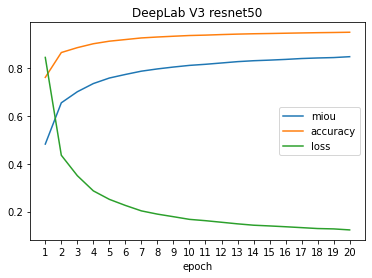

In [38]:
import matplotlib.pyplot as plt
plt.plot(log_epoch['epoch'], log_epoch['miou'], label = 'miou')
plt.plot(log_epoch['epoch'], log_epoch['accuracy'], label = 'accuracy')
plt.plot(log_epoch['epoch'], log_epoch['loss'], label = 'loss')
plt.xticks([i for i in range(1, log_epoch.shape[0]+1)])
plt.title("DeepLab V3 resnet50")
plt.xlabel("epoch")
plt.ylabel("")
plt.legend()
plt.show()

In [33]:
train_X = torch.tensor(train_x[:int(train_x.shape[0]*0.875)], dtype=torch.float32)
train_Y = torch.tensor(train_y[:int(train_y.shape[0]*0.875)], dtype=torch.long)

train_data = torch.utils.data.TensorDataset(train_X.permute(dims=(0, 3, 1, 2)), train_Y)

train_data = torch.utils.data.DataLoader(train_data, batch_size=2, shuffle=True)

In [ ]:
val_X = torch.tensor(train_x[int(train_x.shape[0]*0.875):], dtype=torch.float32)
val_Y = torch.tensor(train_y[int(train_x.shape[0]*0.875):], dtype=torch.long)

val_data = torch.utils.data.TensorDataset(val_X.permute(dims=(0, 3, 1, 2)), val_Y)

val_data = torch.utils.data.DataLoader(val_data, batch_size=2, shuffle=False)

In [ ]:
# validataion
model.eval()

loss_running = AverageMeter('Loss', ':.4e')
acc_running = AverageMeter('Accuracy', ':.3f')
iou = iouCalc(classLabels, validClasses, voidClass = 11)

batch_loss = 0.0
for batch, (x, y) in enumerate(tqdm(val_data, total=len(val_data))):

    x = x.to(device)
    y = y.to(device)

    # forward
    outputs = model(x)
    outputs = outputs['out']

    preds = torch.argmax(outputs, 1)

    # cross-entropy loss
    loss = criterion(outputs, y)

    # Statistics
    bs = x.size(0)
    loss = loss.item()
    loss_running.update(loss, bs)
    corrects = torch.sum((preds == y) & (y != 12))

    nvoid = int((y==12).sum())
    acc = corrects.double()/(bs*res-nvoid)
    acc_running.update(acc, bs)

    # Calculate IoU scores of current batch
    iou.evaluateBatch(preds, y)

miou = iou.outputScores()

# Reduce learning rate
scheduler.step(loss_running.avg) 

print('validataion')
print('loss : {:.4f}   acc : {:.4f}   miou : {:.4f}'.format(loss_running.avg, acc_running.avg, miou))